In [31]:
import os
import sys
import ast
from pprint import pprint
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import itertools as it
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度

In [16]:
root = '/home/wmnlab/D/database'
paths = [s for s in os.listdir(root) if s.startswith('202')]

md_files = []

for date_dir in paths:
    datedir = os.path.join(root, date_dir)
    md_file = [os.path.join(datedir, s) for s in os.listdir(datedir) if s.endswith('.md')]
    md_files += md_file

md_files = sorted(md_files)

# Select dates
# md_files = md_files[:-1]
md_files = [md_files[3]]

pprint(md_files)

['/home/wmnlab/D/database/2023-04-10/2023-04-10.md']


In [17]:
class Experiment():
    
    def __init__(self, dir_name, setting):
        
        self.dir_name = dir_name
        self.setting = setting
        
    def __repr__(self):
        return f'{self.dir_name} -> {self.setting}'

exp_list = []

for md_file in md_files:
    
    md_f = open(md_file, 'r')
    lines = []
    l = md_f.readline()[:-1]
    
    while l:
        
        if l == '#endif':
            break
        lines.append(l)
        l = md_f.readline()[:-1]
        
    md_f.close()
    
    for exp, dic in zip(lines[::2], lines[1::2]):
        
        dictionary = ast.literal_eval(dic)
        parent_dir = os.path.dirname(md_file)
        experiment = Experiment(dir_name = os.path.join(parent_dir, exp), setting=dictionary)
        exp_list.append(experiment)
        
pprint(exp_list)

[/home/wmnlab/D/database/2023-04-10/Experiment1 -> {'qc00': 'All', 'qc01': 'All', 'qc02': 'All', 'qc03': 'All'},
 /home/wmnlab/D/database/2023-04-10/Experiment2 -> {'qc00': 'B1', 'qc01': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 /home/wmnlab/D/database/2023-04-10/Experiment3 -> {'qc00': 'LTE', 'qc01': 'All', 'qc02': 'B7B8', 'qc03': 'B7'}]


# Dual

- Single: rrc_dict = {'All': [f1, f2, f3,...], 'B3':[...]}
- Dual: rrc_dict = {'All+All': [(f1, f2), (f3, f4), (f5, f6),...], 'B3':[...]}

In [27]:
# Set band parameters
_schms = ['B1', 'B3', 'B7', 'B8']
schms = [f'{_schms[i]}+{_schms[j]}' for i in range(len(_schms)) for j in range(i, len(_schms))]
# schms = ['B1+B3','B1+B7','B3+B8']

rrc_dict = {}
nr_dict = {}
lte_dict = {}
ul_pkt_dict = {}
dl_pkt_dict = {}

for schm in schms:
        
    path_list = []
    
    for exp in exp_list:
        
        reverse_dict = {v:k for k, v in exp.setting.items()}
        sch1 = schm.split('+')[0]
        sch2 = schm.split('+')[1]
        # print(sch1, sch2)
        
        try:
            dev1 = reverse_dict[sch1]
            dev2 = reverse_dict[sch2]
        except:
            continue
        
        device_dir1 = os.path.join(exp.dir_name, dev1)
        device_dir2 = os.path.join(exp.dir_name, dev2)
        
        for trace1, trace2 in zip(os.listdir(device_dir1), os.listdir(device_dir2)):
        
            if '#' not in trace1 or '#' not in trace2:
                continue
        
            trace_dir1 = os.path.join(device_dir1, trace1, 'data')
            trace_dir2 = os.path.join(device_dir2, trace2, 'data')
            path_list.append((trace_dir1, trace_dir2))

    path_list = sorted(path_list)
    pprint(path_list)

    rrc_list, nr_list, lte_list, ul_pkt_list, dl_pkt_list = [], [], [], [], []

    for (path1, path2) in path_list:
        
        rrc_list += [(os.path.join(path1, s1), os.path.join(path2, s2)) for s1 in os.listdir(path1) for s2 in os.listdir(path2) if (s1.endswith('_rrc.csv') and s2.endswith('_rrc.csv'))]
        nr_list += [(os.path.join(path1, s1), os.path.join(path2, s2)) for s1 in os.listdir(path1) for s2 in os.listdir(path2) if (s1.endswith('_nr_ml1.csv') and s2.endswith('_nr_ml1.csv'))]
        lte_list += [(os.path.join(path1, s1), os.path.join(path2, s2)) for s1, s2 in zip(os.listdir(path1), os.listdir(path2)) if (s1.endswith('_ml1.csv') and not s1.endswith('_nr_ml1.csv') and s2.endswith('_ml1.csv') and not s2.endswith('_nr_ml1.csv'))]
        ul_pkt_list += [(os.path.join(path1, 'udp_uplk_loss_latency.csv'), os.path.join(path2, 'udp_uplk_loss_latency.csv'))]
        dl_pkt_list += [(os.path.join(path1, 'udp_dnlk_loss_latency.csv'), os.path.join(path2, 'udp_dnlk_loss_latency.csv'))]

    rrc_dict[schm] = rrc_list
    nr_dict[schm] = nr_list
    lte_dict[schm] = lte_list
    ul_pkt_dict[schm] = ul_pkt_list
    dl_pkt_dict[schm] = dl_pkt_list
    

# rrc_dict['All'] = rrc_dict['All'] + rrc_dict['B3B7B8']
# nr_dict['All'] = nr_dict['All'] + nr_dict['B3B7B8']
# lte_dict['All'] = lte_dict['All'] + lte_dict['B3B7B8']
# ul_pkt_dict['All'] = ul_pkt_dict['All'] + ul_pkt_dict['B3B7B8']
# dl_pkt_dict['All'] = dl_pkt_dict['All'] + dl_pkt_dict['B3B7B8']

# schms.remove('B3B7B8')

[('/home/wmnlab/D/database/2023-04-10/Experiment2/qc00/#01/data',
  '/home/wmnlab/D/database/2023-04-10/Experiment2/qc00/#01/data'),
 ('/home/wmnlab/D/database/2023-04-10/Experiment2/qc00/#02/data',
  '/home/wmnlab/D/database/2023-04-10/Experiment2/qc00/#02/data')]
[('/home/wmnlab/D/database/2023-04-10/Experiment2/qc00/#01/data',
  '/home/wmnlab/D/database/2023-04-10/Experiment2/qc01/#01/data'),
 ('/home/wmnlab/D/database/2023-04-10/Experiment2/qc00/#02/data',
  '/home/wmnlab/D/database/2023-04-10/Experiment2/qc01/#02/data')]
[('/home/wmnlab/D/database/2023-04-10/Experiment2/qc00/#01/data',
  '/home/wmnlab/D/database/2023-04-10/Experiment2/qc02/#01/data'),
 ('/home/wmnlab/D/database/2023-04-10/Experiment2/qc00/#02/data',
  '/home/wmnlab/D/database/2023-04-10/Experiment2/qc02/#02/data')]
[('/home/wmnlab/D/database/2023-04-10/Experiment2/qc00/#01/data',
  '/home/wmnlab/D/database/2023-04-10/Experiment2/qc03/#01/data'),
 ('/home/wmnlab/D/database/2023-04-10/Experiment2/qc00/#02/data',
  '

In [19]:
# rrc_dict

{'B1+B1': [('/home/wmnlab/D/database/2023-04-10/Experiment2/qc00/#01/data/diag_log_qc00_2023-04-10_15-45-32_rrc.csv',
   '/home/wmnlab/D/database/2023-04-10/Experiment2/qc00/#01/data/diag_log_qc00_2023-04-10_15-45-32_rrc.csv'),
  ('/home/wmnlab/D/database/2023-04-10/Experiment2/qc00/#02/data/diag_log_qc00_2023-04-10_16-06-58_rrc.csv',
   '/home/wmnlab/D/database/2023-04-10/Experiment2/qc00/#02/data/diag_log_qc00_2023-04-10_16-06-58_rrc.csv')],
 'B1+B3': [('/home/wmnlab/D/database/2023-04-10/Experiment2/qc00/#01/data/diag_log_qc00_2023-04-10_15-45-32_rrc.csv',
   '/home/wmnlab/D/database/2023-04-10/Experiment2/qc01/#01/data/diag_log_qc01_2023-04-10_15-45-32_rrc.csv'),
  ('/home/wmnlab/D/database/2023-04-10/Experiment2/qc00/#02/data/diag_log_qc00_2023-04-10_16-06-58_rrc.csv',
   '/home/wmnlab/D/database/2023-04-10/Experiment2/qc01/#02/data/diag_log_qc01_2023-04-10_16-06-58_rrc.csv')],
 'B1+B7': [('/home/wmnlab/D/database/2023-04-10/Experiment2/qc00/#01/data/diag_log_qc00_2023-04-10_15-45

# Heatmap

In [20]:
pdir = os.path.abspath(os.path.join(os.getcwd(), '.'))  # for jupyter-notebook
sys.path.insert(1, pdir)
from myutils import *

def set_data(df, mode='pcap', tz=0):
    if mode == 'pcap':
        df['seq'] = df['seq'].astype('Int32')
        # df['rpkg'] = df['rpkg'].astype('Int8')
        df['frame_id'] = df['frame_id'].astype('Int32')
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['xmit_time'] = pd.to_datetime(df['xmit_time'])
        df['arr_time'] = pd.to_datetime(df['arr_time'])
        df['Timestamp_epoch'] = df['Timestamp_epoch'].astype('float32')
        df['xmit_time_epoch'] = df['xmit_time_epoch'].astype('float32')
        df['arr_time_epoch'] = df['arr_time_epoch'].astype('float32')
        df['lost'] = df['lost'].astype('boolean')
        df['excl'] = df['excl'].astype('boolean')
        df['latency'] = df['latency'].astype('float32')
    # E-UTRA & NR
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    if mode == 'lte':
        df = df.rename(columns={
            'RSRP(dBm)': 'RSRP',
            'RSRQ(dB)': 'RSRQ',
            'Serving Cell Index': 'serv_cel_index',
            'Number of Neighbor Cells': 'num_neigh_cels',
            'Number of Detected Cells': 'num_cels',
            }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                        'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                        *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
        df.loc[df['serv_cel_index'] == '(MI)Unknown', 'serv_cel_index'] = '3_SCell'
        df['num_cels'] = df['num_neigh_cels'] + 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    if mode == 'nr':
        if df.empty:
            df = pd.DataFrame(columns=['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                                       'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0'])
        else:
            df = df.rename(columns={
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
                }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                            'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                            *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
            df.loc[df['serv_cel_pos'] != 255, 'serv_cel_index'] = 'PSCell'
            df[['PCI','RSRP','RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df.loc[df['serv_cel_pos'] == 255, 'num_neigh_cels'] = df['num_cels']
            df.loc[df['serv_cel_pos'] != 255, 'num_neigh_cels'] = df['num_cels'] - 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    return df

In [22]:
ul_plr_dict = {}

for key, lst in ul_pkt_dict.items():

    ul_plr_dict[key] = []
    
    for (path1, path2) in lst:

        df1 = set_data(pd.read_csv(path1))
        df2 = set_data(pd.read_csv(path2))
        st = max([df1['seq'].array[0], df2['seq'].array[0]])
        et = min([df1['seq'].array[-1], df2['seq'].array[-1]])
        df1 = df1[(df1['seq'] >= st) & (df1['seq'] <= et)].reset_index(drop=True)
        df2 = df2[(df2['seq'] >= st) & (df2['seq'] <= et)].reset_index(drop=True)
        
        df = pd.merge(df1.copy(), df2.copy(), on=['seq'], suffixes=('_m','_s')).copy()
        PLR = (df.lost_m & df.lost_s).mean() * 100
        
        # print(PLR)
        
        ul_plr_dict[key].append(PLR)
    
    ul_plr_dict[key] = np.mean(ul_plr_dict[key])

0.0051972688352270886
0.02222907419491313
0.0
0.0007170669095133267
0.0
0.0
0.0
0.0
0.13772762413351783
2.8610969689581736
0.0
0.0014341338190266533
0.0006496586044033861
0.0007170669095133267
0.14106847997087618
0.10182350115089239
0.06426692194916218
0.07496251874062969
0.0
0.0
0.02468702696732867
0.03872161311371964


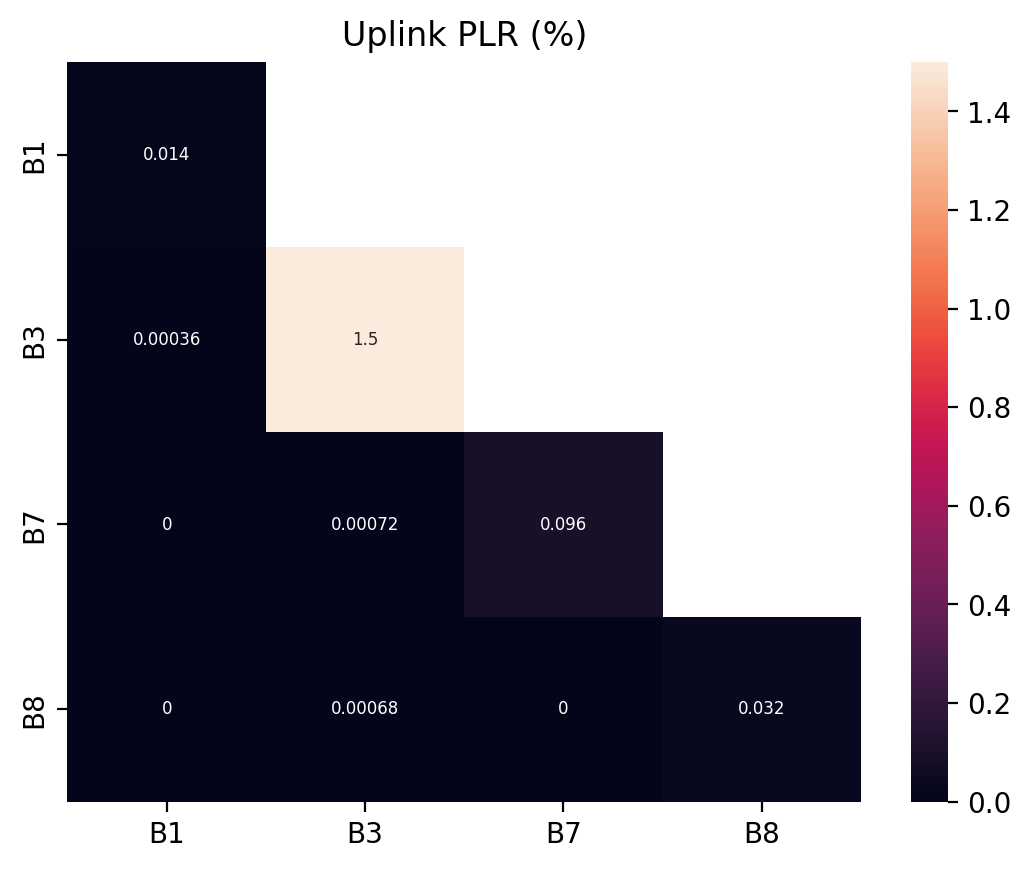

In [32]:
xs = list(it.product(_schms, repeat=2))
xs = ['+'.join([s[0], s[1]]) for s in xs]
xs = np.reshape(xs, (len(_schms), len(_schms)))
mtags = masked(xs.tolist(), mask(len(_schms), mode='upper'))

mat = fill_out_matrix(_schms, mtags, ul_plr_dict)
ax = sns.heatmap(mat.T, annot=True, fmt='.2g', mask=mask(len(_schms)), annot_kws={"size": 6})
ax.set_title(f'Uplink PLR (%)')
plt.show()